## State-Dependent Riccati Equation: осциллятор Ван дер Поля

### Липов Роман (Б03-902)

In [1]:
import numpy as np
import scipy as sci

import sympy as sym
from IPython.display import display, Math
from sympy.simplify.radsimp import collect_sqrt
from sympy.solvers.inequalities import solve_univariate_inequality

from scipy.integrate import solve_ivp, quad
import matplotlib.pyplot as plt

### Осциллятор Ван дер Поля

Рассмотрим осциллятор Ван дер Поля:

$$
\tag{1}
\left[\begin{array}\\
\dot{x_0} \\
\dot{x_1}\\
\end{array}\right]
=
\left[\begin{array}\\
x_1\\
\left(1-\epsilon x_0^2\right)x_1 - x_0 +u\\
\end{array}\right]
$$

Построим траектроии свободной системы $\left(u\equiv0\right)$ при различных значениях $\epsilon$ и $\mathbf{x}_0={\left[\begin{array}\\
2 & 2\\
\end{array}\right]}^T$:

In [2]:
def u_free(x, eps):
    return 0

In [3]:
def a11_func(x, eps):
    return 1-eps*x[0]**2

def rhs(t, x, u, eps=1):
    return np.array([x[1], a11_func(x, eps)*x[1]-x[0]+u(x, eps)])

def get_rhs(u, eps):
    return lambda t, x: rhs(t, x, u, eps)

In [4]:
eps_l = np.arange(0.5, 2.5, 0.5)

t0 = 0
tf = 20
t_span = np.arange(t0, tf, 0.01)

x_0f = np.array([2, 2])

sol_f = [solve_ivp(get_rhs(u_free, eps),(t0,tf), x_0f, t_eval=t_span).y.T for eps in eps_l]

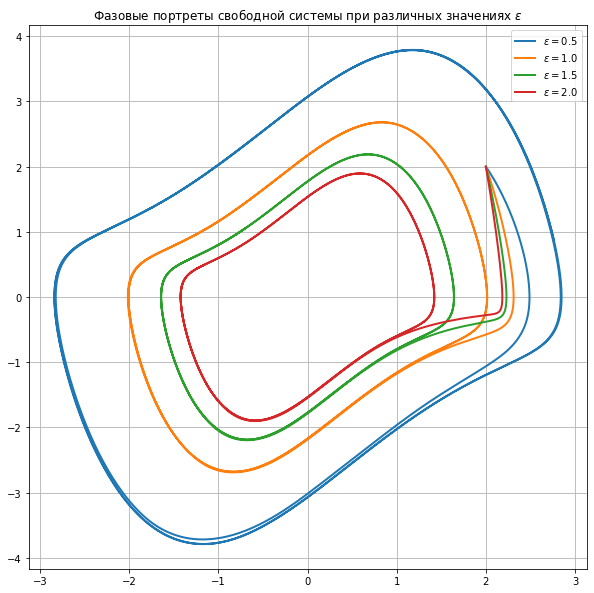

In [5]:
figf = plt.figure(figsize=(10, 10))

axf = figf.add_subplot()
axf.grid()
axf.set_title(r"Фазовые портреты свободной системы при различных значениях $\epsilon$")

for i in range(len(eps_l)):
    axf.plot(sol_f[i][:,0], sol_f[i][:,1], label=r"$\epsilon = "+str(eps_l[i])+"$", linewidth=2)
    
axf.legend()

### SDRE

Из статьи  

[Çimen, Tayfun. "Survey of State-Dependent Riccati Equation in Nonlinear Optimal Feedback Control Synthesis", Journal of Guidance, Control, and Dynamics, Volume 35, Issue 4, 2012, Pages 1025-1047](https://doi.org/10.2514/1.55821)

Поставим задачу нахождения управления $\mathbf{u}(t)$ минимизации функционала:

$$
\tag{2}
J(\mathbf{x}_0, \mathbf{u}(\cdot))=\frac{1}{2}\int^{\infty}_0
\left\{\mathbf{x}^T(t)\mathbf{Q}\left(\mathbf{x}\right)\mathbf{x}(t) + 
\mathbf{u}^T(t)\mathbf{R}\left(\mathbf{x}\right)\mathbf{u}(t)\right\}dt
$$

При условиях:

$$
\tag{3}Q = \left[\begin{array}\\
1 & 0\\
0& 1\\
\end{array}\right],\quad R = \left[1\right]
$$

Представим уравнение $(1)$ в форме SDC:

$$
\tag{4}\dot{\mathbf{x}} = \mathbf{A}(\mathbf{x})\cdot \mathbf{x} + \mathbf{B}(\mathbf{x}) \cdot \mathbf{u}
$$

$$
\tag{5}\mathbf{A} = 
\left[a_{ij}\right]=
\left[\begin{array}\\
0 & 1 \\
-1 & 1-\epsilon x_0^2\\
\end{array}\right],
\quad
\mathbf{B}=
\left[\begin{array}\\
0 \\
1 \\
\end{array}\right]
$$

Применяя к системе алгоритм для задачи о линейно-квадратичном регуляторе, получим:

$$\tag{6}\mathbf{u}(t) = -\mathbf{R}^{-1}(\mathbf{x})\mathbf{B}^{T}(\mathbf{x})\mathbf{P}(\mathbf{x})\cdot \mathbf{x},$$

где $\mathbf{P}(\mathbf{x})$ - симметрическое решение уравнения Риккати с коэффициентами, зависящими от вектора состояния:

$$\tag{7}\mathbf{P}(\mathbf{x})\mathbf{A}(\mathbf{x}) + \mathbf{A}^T(\mathbf{x})\mathbf{P}(\mathbf{x})-\mathbf{P}(\mathbf{x})\mathbf{B}(\mathbf{x})\mathbf{R}^{-1}(\mathbf{x})\mathbf{B}^T(\mathbf{x})\mathbf{P}(\mathbf{x})+\mathbf{Q}(\mathbf{x})=0$$

Получим решение уравнения $(6)$ при помощи библиотеки символьных вычислений SymPy.

In [6]:
# функции для удобного отображения равенств
def dispMath(s):
    return display(Math("$"+s+"$"))
def dispEq(lhs, rhs='0',  mode='='):
    return dispMath(lhs+mode+rhs)
def makelatex(symb):
    return sym.latex(symb)
def dispSymEq(lhs, rhs='0', mode='='):
    return dispEq(makelatex(lhs), makelatex(rhs), mode)

In [7]:
# n-ый главный минор матрицы 
def prMinor(A,n):
    if type(A) != sym.matrices.Matrix:
        raise ValueError("A should be matrix")
    if A.shape[0] != A.shape[1]:
        raise sym.NonSquareMatrixError()
    return A[:n+1,:n+1].det()


def strSylvCr(P, P_str):
    s = P_str+r">0 \Leftrightarrow \left\{\begin{array}\\ "
    
    for i in range(P.shape[0]):
        M = prMinor(P, i)
        try: sol_ineq_s = makelatex(solve_univariate_inequality(sym.simplify(M)>=0, A[1,1]))
        except NotImplementedError: sol_ineq_s = r"\text{Not implemented}"
        s+= r"\Delta_"+str(i)+r" >0 & \Leftrightarrow & "+ sol_ineq_s+r" \\ "
        
    s+= r" \end{array}\right."
    return s

In [8]:
from sympy.abc import gamma, beta, epsilon
A = sym.Matrix(2, 2, sym.symbols('a_{0:2(0:2)}'))
B = sym.Matrix(2, 1, (0,1))
Q = sym.Identity(2)
R = sym.Identity(1)
x = sym.Matrix(2, 1, sym.symbols('x_{0:2}'))

# Элементы симметричной матрицы P
p00, p01, p11 = *sym.symbols('p_{0(0:2)}', real=True), sym.symbols('p_{11}', real=True)

P = sym.Matrix(2, 2, [p00, p01, p01, p11])

In [9]:
# Подстановки "простых" элементов матрицы A
subsA = [(A[0, 0], 0),
         (A[0, 1], 1),
         (A[1, 0], -1)]

# Подстановка для a_{11}
subA11 = [(A[1,1], 1 - epsilon * x[0]**2)]

In [10]:
# Левая часть уравнения Риккати
CARE_lhs = sym.Matrix(P * A + A.T * P - P * B * R.inverse() * B.T *P + Q).subs(subsA)

#### Решение уравнения Риккати
Найдём все решения уравнения $(6)$ и выберем положительно определённое

In [11]:
sol_sym_full = sym.solvers.solve(CARE_lhs, p00, p01, p11, dict=True)
sol_sym_full = [{k: sym.simplify(v) for k,v in sol_sym.items()} for sol_sym in sol_sym_full]


P_full = [P.subs(sol_sym.items()) for sol_sym in sol_sym_full]

for i in range(len(P_full)):
    dispEq("\mathbf{P}_"+str(i), makelatex(P_full[i]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Применим к каждому решению критерий Сильвестра:

In [12]:
for i in range(len(P_full)):
    dispMath(strSylvCr(P_full[i], "\mathbf{P}_"+str(i)))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

$$
\forall a_{11} \in \mathbb{R}:\mathbf{P}_1(\mathbf{x})>0
$$

Выберем $\mathbf{P}(\mathbf{x}) = \mathbf{P}_1(\mathbf{x})$.

Обозначим

$$\tag{8}\begin{array} \\
\gamma & = & \sqrt{a_{22}^2+2\sqrt{2}-1}\\
\beta & = & \sqrt{2}\\
\end{array}
$$

И подставим $(7)$ в $\mathbf{P}(\mathbf{x})$:

In [13]:
# Подстановки \gamma и \beta
subsgb = [(sym.sqrt(A[1, 1]**2 + 2 * sym.sqrt(2) - 1), gamma),
         (sym.sqrt(2), beta)]
# Обратные подстановки 
subsgb_inv = [(sub[1], sub[0]) for sub in subsgb]

In [14]:
# Выбираем одно из решений и записываем его при помощи \gamma и \beta
sol_sym = sol_sym_full[1]
sol_sym = {p: collect_sqrt(v).subs(subsgb) for p,v in sol_sym.items()}

Pa = P.subs(sol_sym.items())
dispEq(r"\tag{9}\mathbf{P}",makelatex(Pa))

<IPython.core.display.Math object>

#### Определение управляющего воздействия

Получим $\mathbf{u}_{SDRE}(\mathbf{x})$ из $(6)$:

In [15]:
u_sym = (-R.inverse()*B.T*P*x)[0]
dispEq(r'{\mathbf{u}_{SDRE}}', makelatex(u_sym))

<IPython.core.display.Math object>

In [16]:
u_sym = u_sym.subs(sol_sym.items())
dispEq(r'\tag{10}\mathbf{u}_{SDRE}', makelatex(u_sym))

<IPython.core.display.Math object>

Подставим $\mathbf{u}_{SDRE}(\mathbf{x})$ в $(4)$:

In [17]:
dx_cont = sym.simplify((A*x+B*u_sym).subs(list(sol_sym.items())+subsA))
dispEq(r"\tag{11}\left[\begin{array}\\ \dot{x_0} \\ \dot{x_1}\\ \end{array}\right]", makelatex(dx_cont))

<IPython.core.display.Math object>

#### Исследование системы с управлением

Покажем, что ${\left[\begin{array}\\
1 & 0\\
\end{array}\right]}^T$ - асимптотически устойчивое положение равновесия при $\mathbf{u}(\mathbf{x}) =\mathbf{u}_{SDRE}(\mathbf{x})$.  
Для этого выберем функцию Ляпунова $V(\mathbf{x}) = \frac{1}{2}\left(\beta x_0^2+x_1^2\right)$

$$
\dot{V}(\mathbf{x}) = \beta x_0\dot{x}_0 + x_1\dot{x}_1 = \beta x_0 x_1-
 \beta x_0 x_1 - \gamma x_1^2 = - \gamma x_1^2 <0
$$

### LQR

Рассмотрим линеаризованную систему $(4)$:

$$
\tag{12}\tilde{\mathbf{A}} = 
\left[a_{ij}\right]=
\left[\begin{array}\\
0 & 1 \\
-1 & 1\\
\end{array}\right],
$$

$$
\tag{13}\dot{\mathbf{x}} = \tilde{\mathbf{A}} \mathbf{x} + \mathbf{B} \mathbf{u}
$$

Решение уравнения $(6)$ для $(12)$ можно получить, подставив в $(9)$ $a_{11}=1$:

In [18]:
dispEq(r"\tag{14}\tilde{\mathbf{P}}", makelatex(sym.simplify(Pa.subs(subsgb_inv + [(A[1, 1], 1)]))))

<IPython.core.display.Math object>

Получим $\mathbf{u}_{LQR}(\mathbf{x})$, подставив $(10)$ $a_{11}=1$

In [19]:
dispEq(r'\tag{15}\mathbf{u}_{LQR}', makelatex(u_sym.subs(subsgb_inv).subs(A[1, 1], 1)))

<IPython.core.display.Math object>

### Аппроксимация опорной функции

В статье:

[R. Durbeck, "An approximation technique for suboptimal control," in IEEE Transactions on Automatic Control, vol. 10, no. 2, pp. 144-149, April 1965, doi: 10.1109/TAC.1965.1098127.](https://doi.org/10.1109/TAC.1965.1098127)

Методом аппроксимации опорной функции $\mathbf{V}(\mathbf{x}_0) = \displaystyle\min_{\mathbf{u}(\mathbf{x})}{J(\mathbf{x}_0, \mathbf{u}(\cdot))}$ получено

$$
\tag{16}\mathbf{u}_{}(\mathbf{x}) = -\left(1.422 x_0 + 3.080 x_1 - 0.219 x_1^3 \right)
$$

### Интегрирование системы

Проинтегрируем систему с управлениями $\mathbf{u}_{LQR}(\mathbf{x})$ и $\mathbf{u}_{SDRE}(\mathbf{x})$. Также найдём значения оптимизируемого функционала.

In [20]:
# Подинтегральная функция функционала
def dJ(t, x, u, eps=1):
    return (np.sum(np.square(x(t))) + np.power(u(x(t), eps), 2)) / 2

In [21]:
def u_sdre(x, eps=1):
    eps = 1
    a11 = a11_func(x, eps)
    gamma = np.sqrt(a11**2 + np.power(2, 3/2)-1)
    beta = np.sqrt(2)
    return -x[0] * (beta - 1) - x[1] * (a11 + gamma)

def u_lqr(x, eps=1):
    return -((np.sqrt(2) - 1) * x[0] + (np.power(2, 3 / 4) + 1) * x[1])

def u_approx(x, eps=1):
    if eps != 1: raise NotImplementedError
    
    return -1.422 * x[0] - 3.080 * x[1] + 0.219 * x[1]**3


u_d = {
    'lqr': u_lqr,
    'sdre': u_sdre,
    'approx': u_approx,
    #'null': lambda x,eps: 0,
}

In [22]:
t0 = 0
tf = 20
t_span = np.arange(t0, tf, 0.01)
x0 = np.array([2, 2])

eps1 = 1
rhs_d = {k: get_rhs(v, eps1) for k,v in u_d.items()}

sol = {k: solve_ivp(v, (t0, tf), x0, t_eval = t_span, dense_output=True) for k,v in rhs_d.items()}

x_solved = {k: v.y.T for k,v in sol.items()}
x_interp = {k: v.sol for k,v in sol.items()}


int_s_lim = 2000
J_d = {k: quad(lambda t: dJ(t, x_interp[k], u_d[k], eps1), t0, tf, limit=int_s_lim) for k in u_d.keys()}

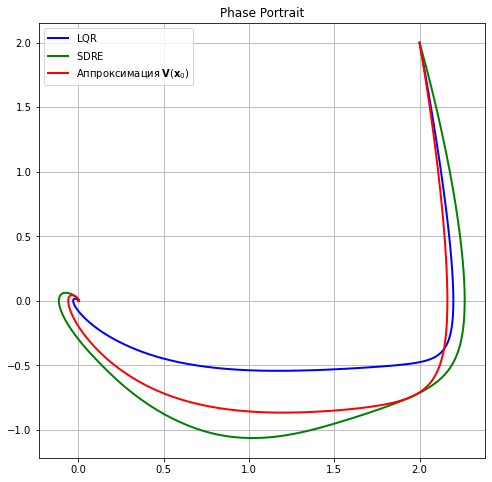

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [23]:
colors = {
    'lqr': "blue",
    'sdre': "green",
    'approx': "red",
}

labels = {
    'lqr': r"\mathrm{LQR}",
    'sdre': r"\mathrm{SDRE}",
    'approx': r"\mathrm{Аппроксимация} \: \mathbf{V}(\mathbf{x}_0)",
}

keys = u_d.keys()



fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot()
#ax ={k: ax for k, ax in zip(keys, [fig1.add_subplot(len(keys), 1, i+1) for i in range(len(keys))])}

ax1.set_title("Phase Portrait")
ax1.grid(True)
for k in keys:
    ax1.plot(x_solved[k][:, 0], x_solved[k][:, 1], color=colors[k], label = '$'+labels[k]+'$', linewidth = 2)
    
ax1.legend()
plt.show()

for k in keys:
    dispEq(r"J_{%s}"%(labels[k]), "%.2f"%(J_d[k][0]))